In [137]:
%matplotlib inline

# 泊松回归与非正常损失¶
此示例说明了在法国电机第三方责任索赔数据集[1]中使用对数线性泊松回归的方法，
并将其与普通最小二乘误差的线性模型和具有泊松损失(和日志链接)的非线性GBRT模型进行了比较。

一些定义：

保单 policy 是保险公司和个人之间的合同：投保人，也就是在这种情况下的车辆司机。
索赔 Claim 是指投保人向保险公司提出的赔偿保险损失的请求。
保险承保期限 exposure 是以年数为单位的某一特定保单的保险承保期限。
索赔频率 frequency 是索赔的数量除以风险，通常以每年的索赔件数来衡量。
在此数据集中，每个示例都对应于一个保险单。可用的功能包括司机年龄、车辆年龄、车辆功率等。

我们的目标是在给定的历史数据中预测一个新投保人在车祸后的预期索赔频率frequency。

．． [1] A. Noll, R. Salzmann and M.V. Wuthrich, Case Study: French Motor，
《案例研究:法国汽车第三方责任索赔》(2018年11月8日)。doi: 10.2139 / ssrn.3164764
<http://dx.doi.org/10.2139/ssrn.3164764>



In [138]:
# Authors: Christian Lorentzen <lorentzen.ch@gmail.com>
#          Roman Yurchak <rth.yurchak@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(plt.style.available[0])  #可以通过下标进行选择适合自己的画图样式
plt.rcParams['font.sans-serif'] = ['SimHei']  #指定默认字体,用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号


## The French Motor Third-Party Liability Claims dataset

##法国汽车第三方责任索赔数据集
让我们从OpenML加载电机索赔数据集:
https://www.openml.org/d/41214

数据集freMTPL2freq包含677，991个电机第三方责任保单的风险特征（主要在一年内观察到）。

In [139]:
from sklearn.datasets import fetch_openml


# df = fetch_openml(data_id=41214, as_frame=True).frame
df = pd.read_csv("./file/claims.cvs")
df

,Unnamed: 0,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
0,458475,3194022.0,0.0,1.00,A,7.0,18.0,55.0,50.0,B2,Diesel,43.0,R24,0.0
1,305693,2217503.0,0.0,0.08,D,4.0,16.0,40.0,55.0,B1,Regular,1765.0,R31,0.0
2,581980,4173158.0,0.0,1.00,A,4.0,13.0,72.0,50.0,B2,Regular,49.0,R24,0.0
3,382393,3044732.0,0.0,0.12,D,10.0,0.0,39.0,50.0,B12,Regular,528.0,R93,0.0
4,304625,2216435.0,0.0,0.23,C,7.0,10.0,57.0,50.0,B11,Diesel,113.0,R91,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223740,510077,4050832.0,0.0,0.09,D,7.0,0.0,54.0,50.0,B12,Diesel,645.0,R94,0.0
223741,182259,1182260.0,0.0,0.70,D,6.0,8.0,48.0,64.0,B1,Diesel,824.0,R91,0.0
223742,110882,1043504.0,2.0,1.00,D,5.0,12.0,25.0,156.0,B2,Diesel,1314.0,R24,2.0
223743,244194,2091438.0,0.0,0.01,C,14.0,1.0,39.0,56.0,B2,Regular,145.0,R72,0.0


In [140]:
# df.to_csv("././file/claims_1.cvs")

索赔数量(ClaimNb)是一个正整数，可以建模为泊松分布。
然后假定为在给定时间间隔内以恒定速率发生的离散事件的数量(Exposure,以年为单位)。

在这里，我们要通过一个(尺度)泊松分布来模拟频率 y = ClaimNb / Exposure 在X上的条件，
并以 Exposure 作为sample_weight。

In [160]:
# 索赔频率
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "平均索赔频率 Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "零索赔的保险承保期限 占比率 Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

平均索赔频率 Average Frequency = 0.09909046935781796
零索赔的保险承保期限 占比率 Fraction of exposure with zero claims = 94.0%


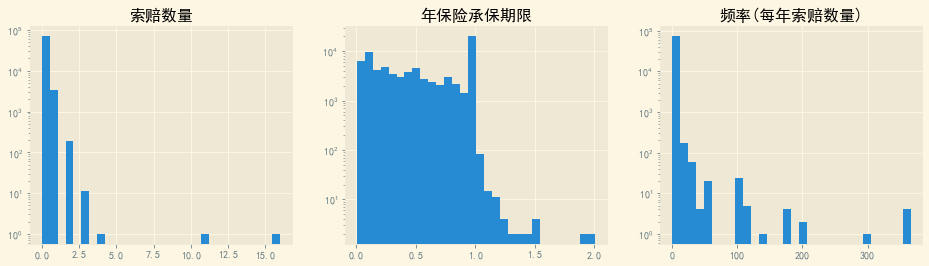

In [159]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("索赔数量")  #索赔数量
# ax0.set_title("Number of claims")  #索赔数量
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("年保险承保期限")  #年保险承保期限
# ax1.set_title("Exposure in years")  #年风险敞口
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("频率(每年索赔数量)")  #频率(每年索赔数量)
# ax2.set_title("Frequency (number of claims per year)")  #频率(每年索赔数量)
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

其余列可用于预测索赔事件的频率。
这些列混杂着不同规模的分类变量和数值变量，可能分布非常不均匀。
为了使线性模型与这些预测器相匹配，因此有必要执行以下标准特征转换:


In [143]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)

ColumnTransformer 将转换器应用于数组或 pandas 数据帧的列。
此估计器允许单独转换输入的不同列或列子集，并且每个转换器生成的特征将串联起来以形成单个特征空间。这对于异构或列式数据非常有用，可以将多个特征提取机制或转换组合到单个转换器中。

In [144]:
linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric",  #列转换器名称
         "passthrough",  #转换器 估计器必须支持拟合和变换
         ["BonusMalus"]  #在其第二个轴上为数据编制索引。整数被解释为位置列，而字符串可以按名称引用 DataFrame 列
         ),

        ("binned_numeric",
         KBinsDiscretizer(n_bins=10),  #KBinsDiscretizer 将连续数据分箱到间隔
         ["VehAge", "DrivAge"]  #车辆年龄,司机年龄
         ),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),  #将分类要素编码为一热数字数组。
            #车辆品牌,车载电源,车辆气体,地区,面积
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

## 不变的预测基线
值得注意的是，超过93%的投保人没有索赔。如果我们将这个问题转化为一个二元分类任务，
它将是非常不平衡的，即使是一个简单的模型，只预测平均值，可以达到93%的准确率。
为了评估所使用的指标的相关性，我们将考虑一个“虚拟”估计器作为基线，它不断预测训练样本的平均频率。



In [145]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),  #使用简单规则进行预测的回归量。此回归量可用作与其他（实际）回归量进行比较的简单基线
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])
#我们的目标是在给定的历史数据中预测一个新投保人在车祸后的预期索赔频率。y标签是 frequency

让我们用3种不同的回归度量来计算这个恒定预测基线的性能：


In [146]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """对测试集上的估计量进行评分."""
    y_pred = estimator.predict(df_test)

    print(
        "均方误差MSE: %.3f"
        % mean_squared_error(  #均方误差回归损失
            df_test["Frequency"],  #真实目标值。
            y_pred,  #预测目标值。
            sample_weight=df_test["Exposure"]  #样本权重
        )  #返回值 非负浮点值（最佳值为0.0）或浮点值数组，每个目标对应一个浮点值。
    )
    print(
        "平均绝对误差MAE: %.3f"
        % mean_absolute_error(  #平均绝对误差回归损失
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )  #返回值 如果多输出为‘raw_values’，则分别为每个输出返回均值绝对错误。如果多输出为‘raw_values’，则分别为每个输出返回均值绝对错误。
    )

    #忽略非积极的预测，因为它们是无效的
    #泊松偏差。
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "警告:估计器产生无效的、非积极的预测 "
            f" for {n_masked} 样品的 {n_samples}. 这些预测 "
            "在计算泊松偏差时忽略."
        )

    print(
        "平均泊松偏差mean Poisson deviance: %.3f"
        % mean_poisson_deviance(  #平均泊松偏差回归损失。泊松偏差等于功率参数power=1的Tweedie偏差。
            df_test["Frequency"][mask],  #真实目标值。 要求y_true> = 0
            y_pred[mask],  #预测目标值。 要求y_pred> 0
            sample_weight=df_test["Exposure"][mask],  #样本权重
        )  #非负浮点值（最佳值为0.0）
    )

In [147]:
print("常平均索赔频率评定Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

常平均索赔频率评定Constant mean frequency evaluation:
均方误差MSE: 0.588
平均绝对误差MAE: 0.188
平均泊松偏差mean Poisson deviance: 0.623


## (广义)线性模型
我们首先用(l2惩罚)最小二乘线性回归模型建模目标变量，更常见的是被称为岭回归。
我们使用了较低的惩罚“alpha”，因为我们认为这样的线性模型不适合于如此大的数据集。



In [148]:
from sklearn.linear_model import Ridge

#管道
ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),  #岭回归
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

泊松偏差不能在模型预测的非正值上计算。对于确实返回了一些非积极预测的模型(例如。
:class: ' ~sklearn.linear_model.Ridge ')忽略相应的样本，
意味着所得到的泊松偏差是近似的。另一种方法可以使用:class:`~ sklearn.compose.transformmedtargetregressor `
将'' y_pred ''映射到严格正域的元估计器。

In [149]:
print("Ridge回归评价 Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge回归评价 Ridge evaluation:
均方误差MSE: 0.584
平均绝对误差MAE: 0.185
警告:估计器产生无效的、非积极的预测  for 188 样品的 73836. 这些预测 在计算泊松偏差时忽略.
平均泊松偏差mean Poisson deviance: 0.599


然后将泊松回归方程拟合到目标变量上。我们设置了
正则化强度“alpha”到大约1e-6除以数
(即样品。“1e-12”)，以模拟Ridge回归者的L2处罚
随着样本的数量不同，术语的规模也不同。
由于泊松回归在内部模拟了预期目标的对数
值而不是直接的期望值(log vs identity link函数)，
X和y之间的关系不再是线性的。因此,
泊松回归器被称为广义线性模型(GLM)，而不是广义线性模型
普通的线性模型，就像山脊回归一样。


In [150]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

In [161]:
poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("泊松回归量_glm评估 PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

泊松回归量_glm评估PoissonRegressor evaluation:
均方误差MSE: 0.585
平均绝对误差MAE: 0.185
平均泊松偏差mean Poisson deviance: 0.594


## Poisson回归的梯度提升回归树
最后，我们将考虑一个非线性模型，即梯度提升回归树。
基于树的模型不需要对分类数据进行独热编码：相反，
我们可以使用OrdinalEncoder对每个类别标签进行任意整数的编码。
通过这种编码，树将把分类特征视为有序的特征，这可能并不总是期望的行为。
然而，对于能够恢复特征分类性质的足够深的树，这种效果是有限的。
OrdinalEncoder的主要优点是它将使训练速度比 OneHotEncoder更快。

梯度提升还提供了用泊松损失(用 implicit log-link function)来拟合树的可能性，而不是默认的最小二乘损失。
在这里，为了保持这个例子的简洁，我们只用Poisson损失来拟合树。



In [162]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),  #对每个类别标签进行任意整数的编码 通过这种编码，树将把分类特征视为有序的特征，这可能并不总是期望的行为。
            #车辆品牌,车载电源,车辆气体,地区,面积
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough",
         #车辆年龄,驾驶人年龄,无索赔奖励,密集
         ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",  #剩余部分删除
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            #基于直方图的梯度提升回归树。
            HistGradientBoostingRegressor(loss="poisson",  #在增压过程中使用的损失函数。请注意，“最小二乘”和“泊松”损失实际上实现了“一半最小二乘损失”和“一半泊松偏差”来简化梯度的计算。此外，“poisson”损失内部使用一个log-link，并要求y >= 0
                                          max_leaf_nodes=128  #每棵树的最大叶节点数。必须严格大于1。如果没有，就没有最大限制。
                                          ),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("泊松梯度增强树_gbrt评估 Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

泊松梯度增强树_gbrt评估 Poisson Gradient Boosted Trees evaluation:
均方误差MSE: 0.578
平均绝对误差MAE: 0.182
平均泊松偏差mean Poisson deviance: 0.580


像上面的泊松GLM一样，梯度增强树模型最小化了泊松偏差。
但由于具有较高的预测能力，其泊松偏差值较低。
用单一的列车/测试分割来评估模型容易受到随机波动的影响。如果计算资源允许，
应该验证交叉验证的性能指标是否会得出类似的结论。
通过比较观测目标值直方图和预测值直方图，也可以看出这些模型之间的定性差异:



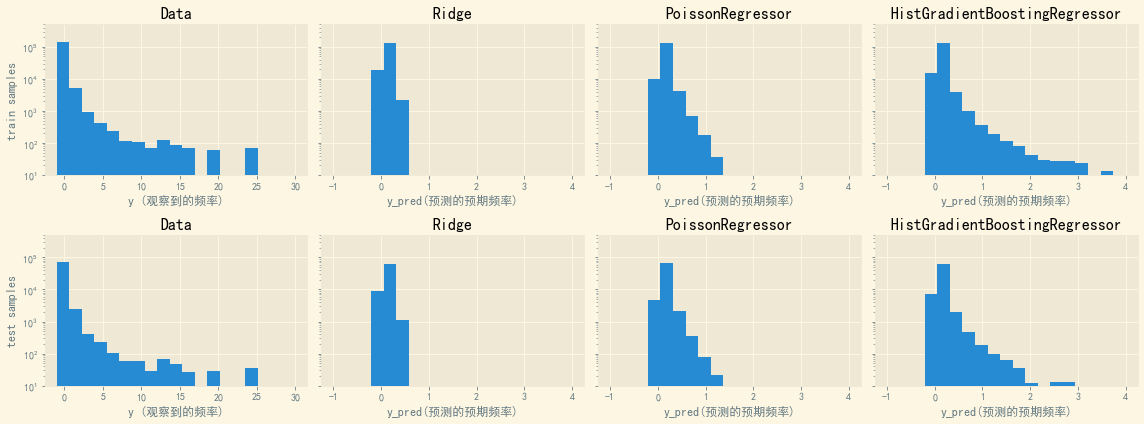

In [157]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (观察到的频率)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred(预测的预期频率)",
            # xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()

实验数据给出了y的长尾分布。在所有模型中，我们都预测了随机变量的期望频率，
因此，与观察到的该随机变量的实现相比，我们的极值必然会更少。
这解释了模型预测直方图的模式不一定与最小值相对应。另外，Ridge的正态分布具有恒定的方差，
而PoissonRegressor和定GradientBoostingRegressor的Poisson分布的方差与预测的期望值成正比。

因此，在所考虑的估计器中，PoissonRegressor和组GRadientBoostingRegressor
比Ridge模型更适合于模拟非负数据的长尾分布，而岭模型对目标变量的分布作了错误的假设。
HistGradientBoostingRegressor估计器具有最大的灵活性，能够预测较高的期望值。

请注意，我们可以对GRadientBoostingRegressor模型使用最小二乘损失。
这将错误地假设一个正常分布的响应变量，就像Ridge模型一样，而且可能还会导致轻微的负面预测。
然而，由于树的灵活性，加上大量的训练样本，梯度提升树仍然表现得比较好，特别是比PoissonRegressor更好。

## 对预测校准的评估
为了保证估计器对不同的投保人类型做出合理的预测，我们可以根据每个模型返回的y_pred来装箱测试样本。然后，对于每个箱子，
我们比较了预测的y_pred的平均值和平均观察到的目标得平均值：


实际索赔数Actual number of claims: 3880.0
预计索赔数量Predicted number of claims by Ridge(alpha=1e-06): 3956.8
预计索赔数量Predicted number of claims by PoissonRegressor(alpha=1e-12, max_iter=300): 3963.4
预计索赔数量Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 3989.3
预计索赔数量Predicted number of claims by DummyRegressor(): 3975.5


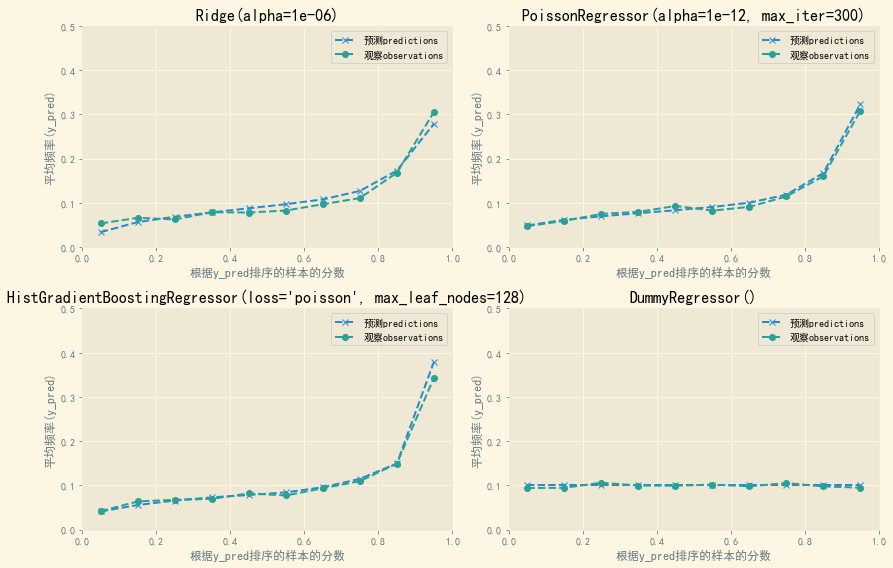

In [163]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)  #np.argsort(a,axis=1): 将矩阵a按照axis排序，并返回排序后的下标
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(  #in enumerate 枚举的意思，把元素一个个列举出来 返回的是元素以及对应的索引
            gen_even_slices(  #生成器创建要生成的切片，最多可达n个。
            len(y_true),
            n_bins) #要生成的切片数。
    ):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"实际索赔数Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # 在管道的最后一步中使用的估计器之后的模型名称。
    print(f"预计索赔数量Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="预测predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="观察observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        # xlabel="Fraction of samples sorted by y_pred",
        xlabel="根据y_pred排序的样本的分数",
        # ylabel="Mean Frequency (y_pred)",
        ylabel="平均频率(y_pred)",
    )
    axi.legend()
plt.tight_layout()

虚拟回归模型预测一个恒定的频率。
这个模型并没有把所有样本都归为相同的并列等级，但是在全球范围内进行了良好的校准(以估计整个总体的平均频率)。
“山脊”回归模型可以预测与数据不匹配的非常低的预期频率。因此，它可能严重低估了一些投保人的风险。
“泊松回归”和“histgradientboostingregression”在预测目标和观测目标之间表现出更好的一致性，特别是对于低预测目标值。
所有预测的总和也证实了“山脊”模型的校准问题:它低估了测试集中索赔总数的3%以上，而其他三个模型可以大致恢复
测试组合的请求总数。
## 评价排名权力
对于一些业务应用程序，我们感兴趣的是模型从最安全的投保人中对风险最大的投保人进行排序的能力，
不管预测的绝对值是多少。在这种情况下，模型评估将把问题作为一个排序问题而不是一个回归问题。
为了从这个角度比较这3个模型，我们可以通过模型预测来绘制测试样本顺序的索赔累积比例与暴露累积比例，
根据每个模型从最安全到最危险。
这条曲线被称为洛伦兹曲线，可以用基尼指数来概括:

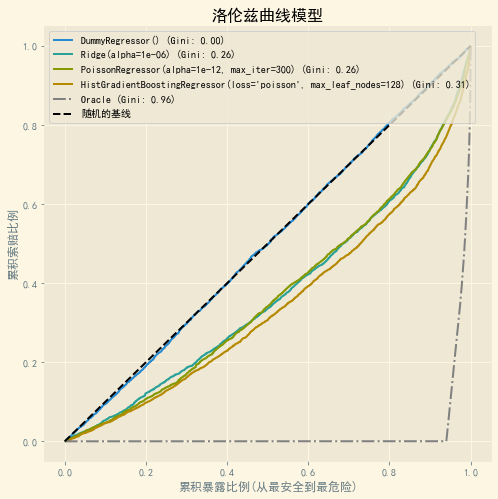

In [158]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # 通过增加预测风险订购样品:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims


fig, ax = plt.subplots(figsize=(8, 8))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(
        df_test["Frequency"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(
    df_test["Frequency"], df_test["Frequency"], df_test["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="随机的基线")
ax.set(
    title="洛伦兹曲线模型",
    # title="Lorenz curves by model",
    xlabel="累积暴露比例(从最安全到最危险)",
    # xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="累积索赔比例",
    # ylabel="Cumulative proportion of claims",
)
ax.legend(loc="upper left")

正如预期的那样，虚拟回归器无法正确地对样本进行排序，因此在这个图中表现最差。
基于树的模型在按风险对保单持有人进行排序方面显著优于两个线性模型。
这三种模型都比概率好得多，但也远远不能做出完美的预测。
最后一点是可以预见的，因为问题的性质:事故的发生主要是由环境原因主导的，
这些原因在数据集的列中没有捕捉到，并且确实可以被认为是纯粹随机的。
线性模型假设输入变量之间没有交互作用，这可能导致欠拟合。
插入一个多项式特征提取器(:func: ' ~sklearn.预处理。多项式特征')确实增加了2点的基尼指数的分辨能力。
特别是，它提高了模型识别前5%风险最高的概况的能力。

## 主要收获

-模型的性能可以通过其产生校准良好的预测和良好的排名的能力来评估。
-模型的校准可以通过绘制按预测风险分类的测试样本组的平均观测值和平均预测值来评估。
- Ridge回归模型的最小二乘损失(以及隐含的身份链接函数的使用)似乎导致了这个模型的校准不当。
- 特别是，它倾向于低估风险，甚至可以预测无效的负频率。
-使用泊松损失和日志链接可以纠正这些问题，并得到一个校准良好的线性模型。
-基尼指数反映了一个模型对预测进行排序的能力，而不考虑其绝对值，因此只评估它们的排名能力。
-尽管在校准方面有所改进，但两种线性模型的排序能力相当，且远低于梯度增强回归树的排序能力。
-泊松偏差作为评估指标计算，反映了模型的校准和排名能力。它还对期望值与响应变量方差之间的理想关系作了线性假设。
- 为了简洁起见，我们没有检验这个假设是否成立。
-传统的回归指标，如平均平方误差和平均绝对误差，很难有意义地解释有许多零的计数值。


In [156]:
plt.show()